In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
#     dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
#                                                                     labels=rates)) # 0-1
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
#     dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                    model.g_opt, model.d_optA], #, model.d_optQ
                                                   feed_dict = {model.states: states, 
                                                                model.actions: actions,
                                                                model.targetQs: targetQs, 
                                                                model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.8923 dlossA:1.0098 dlossQ:0.8426 exploreP:0.9983
Episode:1 meanR:24.0000 R:31.0000 rate:0.0620 gloss:0.8646 dlossA:0.9761 dlossQ:0.8251 exploreP:0.9953
Episode:2 meanR:22.0000 R:18.0000 rate:0.0360 gloss:0.8204 dlossA:0.9529 dlossQ:0.8156 exploreP:0.9935
Episode:3 meanR:22.0000 R:22.0000 rate:0.0440 gloss:0.8243 dlossA:0.9428 dlossQ:0.8165 exploreP:0.9913
Episode:4 meanR:21.8000 R:21.0000 rate:0.0420 gloss:0.8094 dlossA:0.9382 dlossQ:0.8177 exploreP:0.9893
Episode:5 meanR:20.3333 R:13.0000 rate:0.0260 gloss:0.8453 dlossA:0.9510 dlossQ:0.8450 exploreP:0.9880
Episode:6 meanR:20.8571 R:24.0000 rate:0.0480 gloss:0.7776 dlossA:0.9041 dlossQ:0.8146 exploreP:0.9857
Episode:7 meanR:19.5000 R:10.0000 rate:0.0200 gloss:0.8009 dlossA:0.9276 dlossQ:0.8410 exploreP:0.9847
Episode:8 meanR:19.2222 R:17.0000 rate:0.0340 gloss:0.7697 dlossA:0.8962 dlossQ:0.8343 exploreP:0.9830
Episode:9 meanR:23.2000 R:59.0000 rate:0.1180 gloss:0.7509 dlossA:0.8797 

Episode:79 meanR:25.6125 R:13.0000 rate:0.0260 gloss:0.1463 dlossA:0.4274 dlossQ:1.2931 exploreP:0.8166
Episode:80 meanR:25.6543 R:29.0000 rate:0.0580 gloss:0.1487 dlossA:0.4502 dlossQ:1.2949 exploreP:0.8142
Episode:81 meanR:25.9634 R:51.0000 rate:0.1020 gloss:0.1192 dlossA:0.4373 dlossQ:1.2967 exploreP:0.8102
Episode:82 meanR:25.9880 R:28.0000 rate:0.0560 gloss:0.1197 dlossA:0.4282 dlossQ:1.3171 exploreP:0.8079
Episode:83 meanR:25.8929 R:18.0000 rate:0.0360 gloss:0.1051 dlossA:0.4319 dlossQ:1.3225 exploreP:0.8065
Episode:84 meanR:25.8235 R:20.0000 rate:0.0400 gloss:0.0925 dlossA:0.4352 dlossQ:1.3172 exploreP:0.8049
Episode:85 meanR:26.2674 R:64.0000 rate:0.1280 gloss:0.0797 dlossA:0.4301 dlossQ:1.3342 exploreP:0.7998
Episode:86 meanR:26.1954 R:20.0000 rate:0.0400 gloss:0.0708 dlossA:0.4336 dlossQ:1.3460 exploreP:0.7982
Episode:87 meanR:26.1932 R:26.0000 rate:0.0520 gloss:0.0712 dlossA:0.4315 dlossQ:1.3509 exploreP:0.7962
Episode:88 meanR:26.1236 R:20.0000 rate:0.0400 gloss:0.0451 dlos

Episode:157 meanR:28.4200 R:9.0000 rate:0.0180 gloss:-9.8303 dlossA:0.3503 dlossQ:0.8477 exploreP:0.6597
Episode:158 meanR:28.2200 R:9.0000 rate:0.0180 gloss:-10.5032 dlossA:0.3938 dlossQ:0.7785 exploreP:0.6591
Episode:159 meanR:28.0900 R:17.0000 rate:0.0340 gloss:-10.5402 dlossA:0.3748 dlossQ:0.7761 exploreP:0.6580
Episode:160 meanR:28.1900 R:23.0000 rate:0.0460 gloss:-12.0440 dlossA:0.3769 dlossQ:0.8532 exploreP:0.6565
Episode:161 meanR:28.0300 R:11.0000 rate:0.0220 gloss:-12.1793 dlossA:0.3943 dlossQ:0.8646 exploreP:0.6558
Episode:162 meanR:28.2100 R:35.0000 rate:0.0700 gloss:-13.5275 dlossA:0.3750 dlossQ:0.9624 exploreP:0.6536
Episode:163 meanR:27.7000 R:10.0000 rate:0.0200 gloss:-15.4712 dlossA:0.4105 dlossQ:0.9726 exploreP:0.6529
Episode:164 meanR:27.8000 R:33.0000 rate:0.0660 gloss:-17.2924 dlossA:0.3948 dlossQ:1.0746 exploreP:0.6508
Episode:165 meanR:27.6900 R:19.0000 rate:0.0380 gloss:-19.6958 dlossA:0.3880 dlossQ:1.1665 exploreP:0.6496
Episode:166 meanR:27.4800 R:18.0000 rate

Episode:233 meanR:17.9500 R:22.0000 rate:0.0440 gloss:-509.5950 dlossA:0.3618 dlossQ:56.1157 exploreP:0.5783
Episode:234 meanR:17.8400 R:13.0000 rate:0.0260 gloss:-537.8473 dlossA:0.4022 dlossQ:59.5271 exploreP:0.5775
Episode:235 meanR:17.7900 R:14.0000 rate:0.0280 gloss:-546.8841 dlossA:0.3659 dlossQ:62.5439 exploreP:0.5767
Episode:236 meanR:17.4200 R:17.0000 rate:0.0340 gloss:-563.9510 dlossA:0.3873 dlossQ:63.6325 exploreP:0.5758
Episode:237 meanR:17.4000 R:10.0000 rate:0.0200 gloss:-562.9794 dlossA:0.3789 dlossQ:58.4062 exploreP:0.5752
Episode:238 meanR:17.4400 R:15.0000 rate:0.0300 gloss:-607.9976 dlossA:0.4126 dlossQ:63.4728 exploreP:0.5744
Episode:239 meanR:17.4800 R:21.0000 rate:0.0420 gloss:-609.3417 dlossA:0.3766 dlossQ:66.6937 exploreP:0.5732
Episode:240 meanR:17.3400 R:9.0000 rate:0.0180 gloss:-638.6528 dlossA:0.3780 dlossQ:66.0477 exploreP:0.5727
Episode:241 meanR:17.3100 R:15.0000 rate:0.0300 gloss:-671.2623 dlossA:0.3485 dlossQ:74.9416 exploreP:0.5718
Episode:242 meanR:17

Episode:308 meanR:14.2600 R:11.0000 rate:0.0220 gloss:-3042.9202 dlossA:0.4065 dlossQ:340.9011 exploreP:0.5214
Episode:309 meanR:14.4000 R:28.0000 rate:0.0560 gloss:-3281.5854 dlossA:0.3805 dlossQ:382.0263 exploreP:0.5200
Episode:310 meanR:14.4400 R:15.0000 rate:0.0300 gloss:-3352.3337 dlossA:0.3841 dlossQ:408.0370 exploreP:0.5192
Episode:311 meanR:14.3900 R:11.0000 rate:0.0220 gloss:-3411.1787 dlossA:0.3809 dlossQ:383.2467 exploreP:0.5187
Episode:312 meanR:14.4200 R:13.0000 rate:0.0260 gloss:-3546.8052 dlossA:0.4144 dlossQ:402.9959 exploreP:0.5180
Episode:313 meanR:14.4500 R:15.0000 rate:0.0300 gloss:-3581.2205 dlossA:0.3903 dlossQ:399.4056 exploreP:0.5173
Episode:314 meanR:14.4000 R:22.0000 rate:0.0440 gloss:-3576.0986 dlossA:0.4028 dlossQ:446.4365 exploreP:0.5161
Episode:315 meanR:14.3300 R:10.0000 rate:0.0200 gloss:-3769.9915 dlossA:0.3892 dlossQ:419.1374 exploreP:0.5156
Episode:316 meanR:14.2800 R:10.0000 rate:0.0200 gloss:-3606.8176 dlossA:0.3513 dlossQ:433.0123 exploreP:0.5151
E

Episode:382 meanR:14.1400 R:21.0000 rate:0.0420 gloss:-12772.9297 dlossA:0.3794 dlossQ:1485.5912 exploreP:0.4695
Episode:383 meanR:14.1700 R:14.0000 rate:0.0280 gloss:-12979.4980 dlossA:0.4110 dlossQ:1459.2858 exploreP:0.4689
Episode:384 meanR:14.2800 R:20.0000 rate:0.0400 gloss:-13346.4375 dlossA:0.3949 dlossQ:1553.5771 exploreP:0.4680
Episode:385 meanR:14.3200 R:15.0000 rate:0.0300 gloss:-13909.8438 dlossA:0.3642 dlossQ:1627.1570 exploreP:0.4673
Episode:386 meanR:14.3400 R:12.0000 rate:0.0240 gloss:-14084.3486 dlossA:0.3918 dlossQ:1773.5114 exploreP:0.4667
Episode:387 meanR:14.3600 R:13.0000 rate:0.0260 gloss:-14568.6768 dlossA:0.4117 dlossQ:1731.8556 exploreP:0.4661
Episode:388 meanR:14.5100 R:26.0000 rate:0.0520 gloss:-14495.8271 dlossA:0.3827 dlossQ:1669.8044 exploreP:0.4650
Episode:389 meanR:14.5100 R:14.0000 rate:0.0280 gloss:-15236.2607 dlossA:0.3999 dlossQ:1684.3064 exploreP:0.4643
Episode:390 meanR:14.5000 R:10.0000 rate:0.0200 gloss:-15241.0918 dlossA:0.3634 dlossQ:1843.4418

Episode:455 meanR:14.4300 R:17.0000 rate:0.0340 gloss:-39833.3750 dlossA:0.3653 dlossQ:4792.6152 exploreP:0.4246
Episode:456 meanR:14.6100 R:28.0000 rate:0.0560 gloss:-40351.0977 dlossA:0.3585 dlossQ:4826.2407 exploreP:0.4235
Episode:457 meanR:14.3800 R:12.0000 rate:0.0240 gloss:-43503.1445 dlossA:0.3797 dlossQ:5231.6128 exploreP:0.4230
Episode:458 meanR:14.3000 R:10.0000 rate:0.0200 gloss:-41373.4609 dlossA:0.4046 dlossQ:4740.9946 exploreP:0.4226
Episode:459 meanR:14.3300 R:14.0000 rate:0.0280 gloss:-46080.8086 dlossA:0.3876 dlossQ:5964.7983 exploreP:0.4220
Episode:460 meanR:14.2100 R:11.0000 rate:0.0220 gloss:-44661.0469 dlossA:0.4126 dlossQ:4997.0073 exploreP:0.4215
Episode:461 meanR:14.1900 R:15.0000 rate:0.0300 gloss:-43890.0703 dlossA:0.3577 dlossQ:5471.8018 exploreP:0.4209
Episode:462 meanR:14.2100 R:11.0000 rate:0.0220 gloss:-45227.2031 dlossA:0.3474 dlossQ:5323.7051 exploreP:0.4205
Episode:463 meanR:14.2400 R:13.0000 rate:0.0260 gloss:-45405.4453 dlossA:0.4037 dlossQ:5035.2295

Episode:528 meanR:12.5400 R:12.0000 rate:0.0240 gloss:-100031.9609 dlossA:0.3695 dlossQ:13360.1592 exploreP:0.3891
Episode:529 meanR:12.5300 R:12.0000 rate:0.0240 gloss:-100799.8750 dlossA:0.4316 dlossQ:12290.1982 exploreP:0.3886
Episode:530 meanR:12.6100 R:19.0000 rate:0.0380 gloss:-99076.1875 dlossA:0.3770 dlossQ:12293.9160 exploreP:0.3879
Episode:531 meanR:12.6000 R:11.0000 rate:0.0220 gloss:-106629.3672 dlossA:0.3504 dlossQ:13595.6406 exploreP:0.3875
Episode:532 meanR:12.5700 R:11.0000 rate:0.0220 gloss:-105521.8984 dlossA:0.3565 dlossQ:12714.1025 exploreP:0.3871
Episode:533 meanR:12.5300 R:9.0000 rate:0.0180 gloss:-103018.5312 dlossA:0.3767 dlossQ:12430.2666 exploreP:0.3868
Episode:534 meanR:12.4500 R:9.0000 rate:0.0180 gloss:-102778.9922 dlossA:0.3694 dlossQ:12797.2002 exploreP:0.3864
Episode:535 meanR:12.4400 R:11.0000 rate:0.0220 gloss:-99341.7578 dlossA:0.3687 dlossQ:12304.4004 exploreP:0.3860
Episode:536 meanR:12.5000 R:18.0000 rate:0.0360 gloss:-103799.0938 dlossA:0.3923 dlo

Episode:600 meanR:12.2900 R:11.0000 rate:0.0220 gloss:-225747.2500 dlossA:0.3938 dlossQ:30080.0801 exploreP:0.3563
Episode:601 meanR:12.3100 R:15.0000 rate:0.0300 gloss:-207719.0469 dlossA:0.3720 dlossQ:27024.4590 exploreP:0.3557
Episode:602 meanR:12.3200 R:12.0000 rate:0.0240 gloss:-212287.5625 dlossA:0.3444 dlossQ:26538.0254 exploreP:0.3553
Episode:603 meanR:12.3300 R:10.0000 rate:0.0200 gloss:-222847.5469 dlossA:0.3919 dlossQ:27029.4180 exploreP:0.3550
Episode:604 meanR:12.3400 R:12.0000 rate:0.0240 gloss:-212898.3281 dlossA:0.4342 dlossQ:27936.1270 exploreP:0.3546
Episode:605 meanR:12.2900 R:9.0000 rate:0.0180 gloss:-225505.5312 dlossA:0.4200 dlossQ:26800.5723 exploreP:0.3543
Episode:606 meanR:12.2200 R:9.0000 rate:0.0180 gloss:-243140.5312 dlossA:0.3632 dlossQ:31329.4414 exploreP:0.3540
Episode:607 meanR:12.2300 R:11.0000 rate:0.0220 gloss:-231352.7031 dlossA:0.3930 dlossQ:30260.3926 exploreP:0.3536
Episode:608 meanR:12.2700 R:12.0000 rate:0.0240 gloss:-236418.3281 dlossA:0.3491 d

Episode:672 meanR:12.3700 R:11.0000 rate:0.0220 gloss:-422724.4688 dlossA:0.3448 dlossQ:62766.8984 exploreP:0.3278
Episode:673 meanR:12.3200 R:12.0000 rate:0.0240 gloss:-413935.0938 dlossA:0.3908 dlossQ:53443.0273 exploreP:0.3274
Episode:674 meanR:12.3200 R:13.0000 rate:0.0260 gloss:-412798.4688 dlossA:0.3750 dlossQ:50524.5625 exploreP:0.3270
Episode:675 meanR:12.3100 R:8.0000 rate:0.0160 gloss:-422444.4375 dlossA:0.3625 dlossQ:54471.5117 exploreP:0.3267
Episode:676 meanR:12.3100 R:10.0000 rate:0.0200 gloss:-440182.6562 dlossA:0.3626 dlossQ:59019.2812 exploreP:0.3264
Episode:677 meanR:12.2800 R:9.0000 rate:0.0180 gloss:-445602.8750 dlossA:0.3823 dlossQ:59877.3555 exploreP:0.3261
Episode:678 meanR:12.4700 R:30.0000 rate:0.0600 gloss:-439246.1250 dlossA:0.4085 dlossQ:54375.5391 exploreP:0.3252
Episode:679 meanR:12.4400 R:9.0000 rate:0.0180 gloss:-482475.6250 dlossA:0.4013 dlossQ:63997.1406 exploreP:0.3249
Episode:680 meanR:12.3900 R:10.0000 rate:0.0200 gloss:-457395.1562 dlossA:0.3669 dl

Episode:744 meanR:11.7200 R:10.0000 rate:0.0200 gloss:-762753.8750 dlossA:0.3968 dlossQ:96616.4219 exploreP:0.3022
Episode:745 meanR:11.7400 R:12.0000 rate:0.0240 gloss:-787935.3125 dlossA:0.3664 dlossQ:116816.5312 exploreP:0.3018
Episode:746 meanR:11.7200 R:9.0000 rate:0.0180 gloss:-709098.8125 dlossA:0.3406 dlossQ:118173.4609 exploreP:0.3016
Episode:747 meanR:11.7100 R:10.0000 rate:0.0200 gloss:-770860.3750 dlossA:0.3283 dlossQ:111731.2500 exploreP:0.3013
Episode:748 meanR:11.7500 R:16.0000 rate:0.0320 gloss:-812500.1250 dlossA:0.4189 dlossQ:116021.7734 exploreP:0.3008
Episode:749 meanR:11.7000 R:10.0000 rate:0.0200 gloss:-795517.1875 dlossA:0.4148 dlossQ:104436.0000 exploreP:0.3005
Episode:750 meanR:11.6700 R:9.0000 rate:0.0180 gloss:-795688.3750 dlossA:0.3891 dlossQ:113811.0469 exploreP:0.3003
Episode:751 meanR:11.6700 R:13.0000 rate:0.0260 gloss:-757825.0625 dlossA:0.3523 dlossQ:117114.4453 exploreP:0.2999
Episode:752 meanR:11.7000 R:19.0000 rate:0.0380 gloss:-806704.4375 dlossA:0

Episode:815 meanR:11.4900 R:10.0000 rate:0.0200 gloss:-1324204.2500 dlossA:0.4009 dlossQ:183900.4531 exploreP:0.2793
Episode:816 meanR:11.5100 R:13.0000 rate:0.0260 gloss:-1378949.8750 dlossA:0.3575 dlossQ:216624.1875 exploreP:0.2789
Episode:817 meanR:11.4900 R:8.0000 rate:0.0160 gloss:-1336791.7500 dlossA:0.3626 dlossQ:209640.7188 exploreP:0.2787
Episode:818 meanR:11.4700 R:12.0000 rate:0.0240 gloss:-1372096.6250 dlossA:0.3838 dlossQ:190962.4531 exploreP:0.2784
Episode:819 meanR:11.4300 R:11.0000 rate:0.0220 gloss:-1434123.2500 dlossA:0.3911 dlossQ:208054.4531 exploreP:0.2781
Episode:820 meanR:11.3700 R:10.0000 rate:0.0200 gloss:-1383633.5000 dlossA:0.3555 dlossQ:189752.8750 exploreP:0.2778
Episode:821 meanR:11.2900 R:10.0000 rate:0.0200 gloss:-1391593.7500 dlossA:0.3752 dlossQ:202416.7500 exploreP:0.2776
Episode:822 meanR:11.2800 R:11.0000 rate:0.0220 gloss:-1404803.8750 dlossA:0.4157 dlossQ:198376.1406 exploreP:0.2773
Episode:823 meanR:11.2700 R:10.0000 rate:0.0200 gloss:-1199802.62

Episode:886 meanR:11.2200 R:14.0000 rate:0.0280 gloss:-2149552.0000 dlossA:0.3482 dlossQ:318798.0312 exploreP:0.2585
Episode:887 meanR:11.1800 R:13.0000 rate:0.0260 gloss:-2248956.5000 dlossA:0.4130 dlossQ:315137.9688 exploreP:0.2582
Episode:888 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-2299795.5000 dlossA:0.4186 dlossQ:305445.0625 exploreP:0.2580
Episode:889 meanR:11.1600 R:11.0000 rate:0.0220 gloss:-2310153.5000 dlossA:0.4092 dlossQ:308643.0000 exploreP:0.2577
Episode:890 meanR:11.1400 R:9.0000 rate:0.0180 gloss:-2094868.6250 dlossA:0.3417 dlossQ:330401.5000 exploreP:0.2575
Episode:891 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-1976130.2500 dlossA:0.4338 dlossQ:289534.0312 exploreP:0.2572
Episode:892 meanR:11.1300 R:10.0000 rate:0.0200 gloss:-2170357.0000 dlossA:0.3947 dlossQ:304753.9375 exploreP:0.2570
Episode:893 meanR:11.1200 R:11.0000 rate:0.0220 gloss:-2302218.7500 dlossA:0.4250 dlossQ:319614.4688 exploreP:0.2567
Episode:894 meanR:11.2100 R:19.0000 rate:0.0380 gloss:-2197123.75

Episode:957 meanR:11.1200 R:11.0000 rate:0.0220 gloss:-3114277.5000 dlossA:0.3658 dlossQ:423544.2188 exploreP:0.2401
Episode:958 meanR:11.0500 R:9.0000 rate:0.0180 gloss:-3625032.0000 dlossA:0.3507 dlossQ:561713.0625 exploreP:0.2399
Episode:959 meanR:11.1200 R:17.0000 rate:0.0340 gloss:-3444347.7500 dlossA:0.3886 dlossQ:497642.1875 exploreP:0.2395
Episode:960 meanR:11.1200 R:10.0000 rate:0.0200 gloss:-3565786.5000 dlossA:0.3525 dlossQ:546363.8750 exploreP:0.2393
Episode:961 meanR:11.1600 R:14.0000 rate:0.0280 gloss:-3659268.2500 dlossA:0.3518 dlossQ:526717.3125 exploreP:0.2390
Episode:962 meanR:11.1300 R:8.0000 rate:0.0160 gloss:-3359942.5000 dlossA:0.4166 dlossQ:541717.6875 exploreP:0.2388
Episode:963 meanR:11.1600 R:11.0000 rate:0.0220 gloss:-3552597.5000 dlossA:0.3820 dlossQ:582292.8750 exploreP:0.2386
Episode:964 meanR:11.1400 R:11.0000 rate:0.0220 gloss:-3651772.0000 dlossA:0.3984 dlossQ:566206.6875 exploreP:0.2383
Episode:965 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-3616932.750

Episode:1027 meanR:11.1600 R:11.0000 rate:0.0220 gloss:-5250922.0000 dlossA:0.3567 dlossQ:793713.2500 exploreP:0.2229
Episode:1028 meanR:11.2100 R:15.0000 rate:0.0300 gloss:-5036002.0000 dlossA:0.3947 dlossQ:722231.5625 exploreP:0.2226
Episode:1029 meanR:11.2100 R:10.0000 rate:0.0200 gloss:-4989175.5000 dlossA:0.3626 dlossQ:704800.6250 exploreP:0.2224
Episode:1030 meanR:11.1500 R:10.0000 rate:0.0200 gloss:-5299850.5000 dlossA:0.3629 dlossQ:739871.8125 exploreP:0.2222
Episode:1031 meanR:11.0900 R:8.0000 rate:0.0160 gloss:-4860538.5000 dlossA:0.3445 dlossQ:753174.3125 exploreP:0.2220
Episode:1032 meanR:11.1100 R:11.0000 rate:0.0220 gloss:-5654528.5000 dlossA:0.3804 dlossQ:786611.1875 exploreP:0.2218
Episode:1033 meanR:11.1200 R:11.0000 rate:0.0220 gloss:-5077582.5000 dlossA:0.3632 dlossQ:749184.4375 exploreP:0.2216
Episode:1034 meanR:11.1200 R:12.0000 rate:0.0240 gloss:-5265485.5000 dlossA:0.3545 dlossQ:825191.4375 exploreP:0.2213
Episode:1035 meanR:11.1000 R:9.0000 rate:0.0180 gloss:-48

Episode:1097 meanR:10.8000 R:8.0000 rate:0.0160 gloss:-8022203.5000 dlossA:0.3755 dlossQ:1229721.5000 exploreP:0.2077
Episode:1098 meanR:10.7500 R:14.0000 rate:0.0280 gloss:-7968385.5000 dlossA:0.3764 dlossQ:1181915.1250 exploreP:0.2074
Episode:1099 meanR:10.7500 R:10.0000 rate:0.0200 gloss:-7804189.0000 dlossA:0.3479 dlossQ:1188659.7500 exploreP:0.2072
Episode:1100 meanR:10.7100 R:9.0000 rate:0.0180 gloss:-7838594.0000 dlossA:0.4001 dlossQ:1109991.8750 exploreP:0.2071
Episode:1101 meanR:10.7000 R:10.0000 rate:0.0200 gloss:-8143003.0000 dlossA:0.3496 dlossQ:1270622.6250 exploreP:0.2069
Episode:1102 meanR:10.6400 R:8.0000 rate:0.0160 gloss:-7239652.5000 dlossA:0.3538 dlossQ:1414973.2500 exploreP:0.2067
Episode:1103 meanR:10.5900 R:8.0000 rate:0.0160 gloss:-7951526.0000 dlossA:0.3955 dlossQ:1160953.2500 exploreP:0.2065
Episode:1104 meanR:10.5900 R:10.0000 rate:0.0200 gloss:-8158293.5000 dlossA:0.3927 dlossQ:1171443.5000 exploreP:0.2064
Episode:1105 meanR:10.6000 R:11.0000 rate:0.0220 glo

Episode:1166 meanR:10.4200 R:9.0000 rate:0.0180 gloss:-10800611.0000 dlossA:0.3694 dlossQ:1703664.3750 exploreP:0.1939
Episode:1167 meanR:10.4100 R:10.0000 rate:0.0200 gloss:-10228515.0000 dlossA:0.3651 dlossQ:1466512.7500 exploreP:0.1937
Episode:1168 meanR:10.4000 R:9.0000 rate:0.0180 gloss:-10118466.0000 dlossA:0.3691 dlossQ:1659846.2500 exploreP:0.1936
Episode:1169 meanR:10.4200 R:11.0000 rate:0.0220 gloss:-10712356.0000 dlossA:0.3909 dlossQ:1542904.1250 exploreP:0.1934
Episode:1170 meanR:10.4400 R:11.0000 rate:0.0220 gloss:-11972460.0000 dlossA:0.3560 dlossQ:2181020.2500 exploreP:0.1931
Episode:1171 meanR:10.4400 R:9.0000 rate:0.0180 gloss:-11124070.0000 dlossA:0.3971 dlossQ:1640341.7500 exploreP:0.1930
Episode:1172 meanR:10.4300 R:10.0000 rate:0.0200 gloss:-11086107.0000 dlossA:0.3374 dlossQ:1834606.2500 exploreP:0.1928
Episode:1173 meanR:10.4300 R:10.0000 rate:0.0200 gloss:-10846251.0000 dlossA:0.4060 dlossQ:1627603.7500 exploreP:0.1926
Episode:1174 meanR:10.4000 R:8.0000 rate:0.

Episode:1235 meanR:10.4700 R:9.0000 rate:0.0180 gloss:-15400576.0000 dlossA:0.3664 dlossQ:2682124.2500 exploreP:0.1810
Episode:1236 meanR:10.4700 R:11.0000 rate:0.0220 gloss:-15204058.0000 dlossA:0.3759 dlossQ:2579640.2500 exploreP:0.1808
Episode:1237 meanR:10.5200 R:14.0000 rate:0.0280 gloss:-15075745.0000 dlossA:0.3663 dlossQ:2695856.0000 exploreP:0.1806
Episode:1238 meanR:10.5700 R:14.0000 rate:0.0280 gloss:-15987534.0000 dlossA:0.3851 dlossQ:2612847.5000 exploreP:0.1804
Episode:1239 meanR:10.5600 R:10.0000 rate:0.0200 gloss:-16442278.0000 dlossA:0.3144 dlossQ:2992630.5000 exploreP:0.1802
Episode:1240 meanR:10.6100 R:14.0000 rate:0.0280 gloss:-16088848.0000 dlossA:0.3342 dlossQ:2726142.5000 exploreP:0.1800
Episode:1241 meanR:10.6300 R:11.0000 rate:0.0220 gloss:-15510068.0000 dlossA:0.3780 dlossQ:2518042.7500 exploreP:0.1798
Episode:1242 meanR:10.5700 R:11.0000 rate:0.0220 gloss:-15140340.0000 dlossA:0.3354 dlossQ:2657717.7500 exploreP:0.1796
Episode:1243 meanR:10.6300 R:15.0000 rate

Episode:1304 meanR:10.6000 R:8.0000 rate:0.0160 gloss:-21575694.0000 dlossA:0.3550 dlossQ:3817493.0000 exploreP:0.1689
Episode:1305 meanR:10.6200 R:13.0000 rate:0.0260 gloss:-21189724.0000 dlossA:0.3387 dlossQ:3520658.7500 exploreP:0.1687
Episode:1306 meanR:10.6200 R:11.0000 rate:0.0220 gloss:-21175230.0000 dlossA:0.3749 dlossQ:3130572.2500 exploreP:0.1685
Episode:1307 meanR:10.6100 R:10.0000 rate:0.0200 gloss:-21018436.0000 dlossA:0.3349 dlossQ:3795325.5000 exploreP:0.1683
Episode:1308 meanR:10.6200 R:10.0000 rate:0.0200 gloss:-20770932.0000 dlossA:0.3766 dlossQ:4340092.5000 exploreP:0.1682
Episode:1309 meanR:10.6300 R:10.0000 rate:0.0200 gloss:-23239768.0000 dlossA:0.3555 dlossQ:4190251.2500 exploreP:0.1680
Episode:1310 meanR:10.6000 R:10.0000 rate:0.0200 gloss:-20743996.0000 dlossA:0.3434 dlossQ:3634325.5000 exploreP:0.1679
Episode:1311 meanR:10.6200 R:11.0000 rate:0.0220 gloss:-23422786.0000 dlossA:0.3535 dlossQ:3993184.0000 exploreP:0.1677
Episode:1312 meanR:10.6200 R:12.0000 rate

Episode:1373 meanR:10.2000 R:10.0000 rate:0.0200 gloss:-31773712.0000 dlossA:0.3433 dlossQ:6348576.5000 exploreP:0.1581
Episode:1374 meanR:10.2000 R:10.0000 rate:0.0200 gloss:-32062576.0000 dlossA:0.3840 dlossQ:5904520.5000 exploreP:0.1579
Episode:1375 meanR:10.1800 R:11.0000 rate:0.0220 gloss:-33958980.0000 dlossA:0.3614 dlossQ:5703436.5000 exploreP:0.1578
Episode:1376 meanR:10.1500 R:8.0000 rate:0.0160 gloss:-25867192.0000 dlossA:0.3392 dlossQ:6406191.0000 exploreP:0.1577
Episode:1377 meanR:10.1600 R:9.0000 rate:0.0180 gloss:-28345352.0000 dlossA:0.3007 dlossQ:5629492.5000 exploreP:0.1575
Episode:1378 meanR:10.1300 R:11.0000 rate:0.0220 gloss:-28892984.0000 dlossA:0.3717 dlossQ:5167798.0000 exploreP:0.1574
Episode:1379 meanR:10.1300 R:10.0000 rate:0.0200 gloss:-29791766.0000 dlossA:0.3413 dlossQ:5940471.0000 exploreP:0.1572
Episode:1380 meanR:10.1300 R:10.0000 rate:0.0200 gloss:-31273606.0000 dlossA:0.3360 dlossQ:6101763.0000 exploreP:0.1571
Episode:1381 meanR:10.1300 R:9.0000 rate:0

Episode:1442 meanR:10.1400 R:16.0000 rate:0.0320 gloss:-42596848.0000 dlossA:0.3755 dlossQ:7111549.0000 exploreP:0.1480
Episode:1443 meanR:10.1400 R:8.0000 rate:0.0160 gloss:-41602832.0000 dlossA:0.3733 dlossQ:6503684.0000 exploreP:0.1479
Episode:1444 meanR:10.1600 R:10.0000 rate:0.0200 gloss:-41899244.0000 dlossA:0.3511 dlossQ:7516504.0000 exploreP:0.1478
Episode:1445 meanR:10.1700 R:14.0000 rate:0.0280 gloss:-40279704.0000 dlossA:0.3071 dlossQ:8010617.0000 exploreP:0.1476
Episode:1446 meanR:10.1800 R:11.0000 rate:0.0220 gloss:-40440804.0000 dlossA:0.3617 dlossQ:7158723.0000 exploreP:0.1474
Episode:1447 meanR:10.1700 R:9.0000 rate:0.0180 gloss:-43969592.0000 dlossA:0.3574 dlossQ:8337166.0000 exploreP:0.1473
Episode:1448 meanR:10.1100 R:10.0000 rate:0.0200 gloss:-41742260.0000 dlossA:0.3214 dlossQ:7805485.0000 exploreP:0.1472
Episode:1449 meanR:10.1100 R:9.0000 rate:0.0180 gloss:-47293844.0000 dlossA:0.3643 dlossQ:8532644.0000 exploreP:0.1470
Episode:1450 meanR:10.1300 R:11.0000 rate:0

Episode:1511 meanR:10.2200 R:9.0000 rate:0.0180 gloss:-52761396.0000 dlossA:0.3752 dlossQ:9491942.0000 exploreP:0.1386
Episode:1512 meanR:10.2000 R:9.0000 rate:0.0180 gloss:-51680004.0000 dlossA:0.3697 dlossQ:10253636.0000 exploreP:0.1385
Episode:1513 meanR:10.2400 R:13.0000 rate:0.0260 gloss:-53579952.0000 dlossA:0.3317 dlossQ:10478028.0000 exploreP:0.1383
Episode:1514 meanR:10.2500 R:11.0000 rate:0.0220 gloss:-55052912.0000 dlossA:0.3681 dlossQ:10416532.0000 exploreP:0.1382
Episode:1515 meanR:10.2500 R:10.0000 rate:0.0200 gloss:-48852096.0000 dlossA:0.3117 dlossQ:13084482.0000 exploreP:0.1380
Episode:1516 meanR:10.2600 R:11.0000 rate:0.0220 gloss:-52328688.0000 dlossA:0.3672 dlossQ:9200839.0000 exploreP:0.1379
Episode:1517 meanR:10.2300 R:8.0000 rate:0.0160 gloss:-54033528.0000 dlossA:0.3748 dlossQ:10349277.0000 exploreP:0.1378
Episode:1518 meanR:10.2200 R:9.0000 rate:0.0180 gloss:-45434700.0000 dlossA:0.3260 dlossQ:8393813.0000 exploreP:0.1377
Episode:1519 meanR:10.2000 R:10.0000 ra

Episode:1580 meanR:10.1500 R:13.0000 rate:0.0260 gloss:-66180520.0000 dlossA:0.4064 dlossQ:12745463.0000 exploreP:0.1299
Episode:1581 meanR:10.1700 R:11.0000 rate:0.0220 gloss:-68800720.0000 dlossA:0.3592 dlossQ:14168724.0000 exploreP:0.1298
Episode:1582 meanR:10.1800 R:10.0000 rate:0.0200 gloss:-64837236.0000 dlossA:0.3716 dlossQ:10172038.0000 exploreP:0.1296
Episode:1583 meanR:10.1700 R:11.0000 rate:0.0220 gloss:-70601632.0000 dlossA:0.3561 dlossQ:13244183.0000 exploreP:0.1295
Episode:1584 meanR:10.2000 R:12.0000 rate:0.0240 gloss:-67029968.0000 dlossA:0.3604 dlossQ:11272001.0000 exploreP:0.1294
Episode:1585 meanR:10.1900 R:8.0000 rate:0.0160 gloss:-76417216.0000 dlossA:0.3685 dlossQ:14929287.0000 exploreP:0.1293
Episode:1586 meanR:10.2000 R:11.0000 rate:0.0220 gloss:-74027696.0000 dlossA:0.3947 dlossQ:12497597.0000 exploreP:0.1291
Episode:1587 meanR:10.2000 R:11.0000 rate:0.0220 gloss:-67821016.0000 dlossA:0.3885 dlossQ:10280787.0000 exploreP:0.1290
Episode:1588 meanR:10.2000 R:10.0

Episode:1649 meanR:9.9800 R:12.0000 rate:0.0240 gloss:-85676112.0000 dlossA:0.3195 dlossQ:18367012.0000 exploreP:0.1219
Episode:1650 meanR:9.9900 R:10.0000 rate:0.0200 gloss:-85502928.0000 dlossA:0.3719 dlossQ:13934198.0000 exploreP:0.1218
Episode:1651 meanR:9.9900 R:10.0000 rate:0.0200 gloss:-89158480.0000 dlossA:0.3563 dlossQ:16961750.0000 exploreP:0.1217
Episode:1652 meanR:10.0100 R:10.0000 rate:0.0200 gloss:-87408360.0000 dlossA:0.3535 dlossQ:15939856.0000 exploreP:0.1216
Episode:1653 meanR:10.0400 R:12.0000 rate:0.0240 gloss:-84123432.0000 dlossA:0.3428 dlossQ:17537456.0000 exploreP:0.1215
Episode:1654 meanR:10.0700 R:12.0000 rate:0.0240 gloss:-98290296.0000 dlossA:0.3649 dlossQ:20574740.0000 exploreP:0.1213
Episode:1655 meanR:10.0600 R:8.0000 rate:0.0160 gloss:-95684048.0000 dlossA:0.3784 dlossQ:16645804.0000 exploreP:0.1212
Episode:1656 meanR:10.0600 R:9.0000 rate:0.0180 gloss:-91547048.0000 dlossA:0.3573 dlossQ:16871304.0000 exploreP:0.1211
Episode:1657 meanR:10.0600 R:10.0000 

Episode:1718 meanR:9.8200 R:8.0000 rate:0.0160 gloss:-94784544.0000 dlossA:0.3375 dlossQ:19646264.0000 exploreP:0.1146
Episode:1719 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-119015040.0000 dlossA:0.3294 dlossQ:22958528.0000 exploreP:0.1145
Episode:1720 meanR:9.8300 R:11.0000 rate:0.0220 gloss:-114488264.0000 dlossA:0.3395 dlossQ:28327130.0000 exploreP:0.1144
Episode:1721 meanR:9.8200 R:9.0000 rate:0.0180 gloss:-111911288.0000 dlossA:0.3691 dlossQ:24179622.0000 exploreP:0.1143
Episode:1722 meanR:9.8800 R:14.0000 rate:0.0280 gloss:-116942712.0000 dlossA:0.3927 dlossQ:20882404.0000 exploreP:0.1142
Episode:1723 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-128693720.0000 dlossA:0.3723 dlossQ:22955300.0000 exploreP:0.1141
Episode:1724 meanR:9.8900 R:9.0000 rate:0.0180 gloss:-131172776.0000 dlossA:0.3430 dlossQ:25491708.0000 exploreP:0.1140
Episode:1725 meanR:9.9000 R:10.0000 rate:0.0200 gloss:-118120208.0000 dlossA:0.3506 dlossQ:23447444.0000 exploreP:0.1139
Episode:1726 meanR:9.9400 R:13.0000 ra

Episode:1786 meanR:9.9300 R:13.0000 rate:0.0260 gloss:-153613376.0000 dlossA:0.3526 dlossQ:29979292.0000 exploreP:0.1077
Episode:1787 meanR:9.9200 R:9.0000 rate:0.0180 gloss:-156329120.0000 dlossA:0.3524 dlossQ:29979470.0000 exploreP:0.1076
Episode:1788 meanR:9.9100 R:9.0000 rate:0.0180 gloss:-143812000.0000 dlossA:0.3403 dlossQ:30599850.0000 exploreP:0.1076
Episode:1789 meanR:9.9000 R:11.0000 rate:0.0220 gloss:-140615728.0000 dlossA:0.3282 dlossQ:27531784.0000 exploreP:0.1074
Episode:1790 meanR:9.9000 R:9.0000 rate:0.0180 gloss:-148768848.0000 dlossA:0.3727 dlossQ:24991784.0000 exploreP:0.1074
Episode:1791 meanR:9.8900 R:9.0000 rate:0.0180 gloss:-150892992.0000 dlossA:0.3701 dlossQ:29458328.0000 exploreP:0.1073
Episode:1792 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-150586448.0000 dlossA:0.3302 dlossQ:31358486.0000 exploreP:0.1072
Episode:1793 meanR:9.9100 R:13.0000 rate:0.0260 gloss:-154151088.0000 dlossA:0.4051 dlossQ:27922696.0000 exploreP:0.1071
Episode:1794 meanR:9.9000 R:10.0000 r

Episode:1854 meanR:9.9100 R:11.0000 rate:0.0220 gloss:-205931312.0000 dlossA:0.3742 dlossQ:38578204.0000 exploreP:0.1014
Episode:1855 meanR:9.9000 R:9.0000 rate:0.0180 gloss:-198811840.0000 dlossA:0.4076 dlossQ:34642848.0000 exploreP:0.1013
Episode:1856 meanR:9.9000 R:10.0000 rate:0.0200 gloss:-205990880.0000 dlossA:0.3707 dlossQ:34933112.0000 exploreP:0.1012
Episode:1857 meanR:9.9500 R:14.0000 rate:0.0280 gloss:-187432496.0000 dlossA:0.3474 dlossQ:36459012.0000 exploreP:0.1011
Episode:1858 meanR:9.9800 R:12.0000 rate:0.0240 gloss:-186449616.0000 dlossA:0.3746 dlossQ:38457956.0000 exploreP:0.1010
Episode:1859 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-168148288.0000 dlossA:0.3487 dlossQ:40561388.0000 exploreP:0.1009
Episode:1860 meanR:9.9700 R:10.0000 rate:0.0200 gloss:-177939904.0000 dlossA:0.4093 dlossQ:29349110.0000 exploreP:0.1008
Episode:1861 meanR:9.9700 R:10.0000 rate:0.0200 gloss:-185622112.0000 dlossA:0.2810 dlossQ:46476068.0000 exploreP:0.1007
Episode:1862 meanR:9.9800 R:11.00

Episode:1922 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-241326416.0000 dlossA:0.3619 dlossQ:46691476.0000 exploreP:0.0954
Episode:1923 meanR:9.7900 R:11.0000 rate:0.0220 gloss:-300040032.0000 dlossA:0.3353 dlossQ:69531088.0000 exploreP:0.0953
Episode:1924 meanR:9.8000 R:10.0000 rate:0.0200 gloss:-209633584.0000 dlossA:0.3574 dlossQ:40495312.0000 exploreP:0.0953
Episode:1925 meanR:9.8100 R:11.0000 rate:0.0220 gloss:-246330016.0000 dlossA:0.3827 dlossQ:42138580.0000 exploreP:0.0952
Episode:1926 meanR:9.8000 R:8.0000 rate:0.0160 gloss:-228331008.0000 dlossA:0.3476 dlossQ:50633752.0000 exploreP:0.0951
Episode:1927 meanR:9.8000 R:9.0000 rate:0.0180 gloss:-259631040.0000 dlossA:0.4064 dlossQ:53158236.0000 exploreP:0.0950
Episode:1928 meanR:9.8200 R:10.0000 rate:0.0200 gloss:-261324032.0000 dlossA:0.3943 dlossQ:46344648.0000 exploreP:0.0949
Episode:1929 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-242410784.0000 dlossA:0.3920 dlossQ:49294500.0000 exploreP:0.0949
Episode:1930 meanR:9.8500 R:12.000

Episode:1990 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-331920352.0000 dlossA:0.3579 dlossQ:64747092.0000 exploreP:0.0899
Episode:1991 meanR:9.8400 R:9.0000 rate:0.0180 gloss:-288372096.0000 dlossA:0.3817 dlossQ:54663956.0000 exploreP:0.0898
Episode:1992 meanR:9.8400 R:9.0000 rate:0.0180 gloss:-289109120.0000 dlossA:0.3227 dlossQ:57254968.0000 exploreP:0.0897
Episode:1993 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-282882784.0000 dlossA:0.3462 dlossQ:56065032.0000 exploreP:0.0897
Episode:1994 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-302510016.0000 dlossA:0.3363 dlossQ:74449352.0000 exploreP:0.0896
Episode:1995 meanR:9.8200 R:9.0000 rate:0.0180 gloss:-297105120.0000 dlossA:0.3338 dlossQ:72037096.0000 exploreP:0.0895
Episode:1996 meanR:9.8200 R:8.0000 rate:0.0160 gloss:-307745920.0000 dlossA:0.3673 dlossQ:54674784.0000 exploreP:0.0894
Episode:1997 meanR:9.8200 R:9.0000 rate:0.0180 gloss:-281575296.0000 dlossA:0.3567 dlossQ:50762740.0000 exploreP:0.0894
Episode:1998 meanR:9.8600 R:12.0000 ra

Episode:2058 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-332482624.0000 dlossA:0.4053 dlossQ:65245836.0000 exploreP:0.0848
Episode:2059 meanR:9.8300 R:9.0000 rate:0.0180 gloss:-314644864.0000 dlossA:0.4135 dlossQ:64786972.0000 exploreP:0.0847
Episode:2060 meanR:9.8500 R:10.0000 rate:0.0200 gloss:-340693568.0000 dlossA:0.3585 dlossQ:83374720.0000 exploreP:0.0846
Episode:2061 meanR:9.8100 R:9.0000 rate:0.0180 gloss:-308585984.0000 dlossA:0.3418 dlossQ:80184984.0000 exploreP:0.0845
Episode:2062 meanR:9.8000 R:10.0000 rate:0.0200 gloss:-328193344.0000 dlossA:0.3354 dlossQ:87404040.0000 exploreP:0.0845
Episode:2063 meanR:9.8000 R:9.0000 rate:0.0180 gloss:-357396352.0000 dlossA:0.3629 dlossQ:78671968.0000 exploreP:0.0844
Episode:2064 meanR:9.8000 R:10.0000 rate:0.0200 gloss:-392926784.0000 dlossA:0.3888 dlossQ:71915752.0000 exploreP:0.0843
Episode:2065 meanR:9.8100 R:10.0000 rate:0.0200 gloss:-337235136.0000 dlossA:0.3502 dlossQ:82422032.0000 exploreP:0.0843
Episode:2066 meanR:9.8000 R:9.0000 

Episode:2126 meanR:9.8100 R:10.0000 rate:0.0200 gloss:-414441408.0000 dlossA:0.3834 dlossQ:91338896.0000 exploreP:0.0799
Episode:2127 meanR:9.8000 R:9.0000 rate:0.0180 gloss:-442289024.0000 dlossA:0.4278 dlossQ:80327816.0000 exploreP:0.0799
Episode:2128 meanR:9.7800 R:8.0000 rate:0.0160 gloss:-417393984.0000 dlossA:0.3717 dlossQ:110920048.0000 exploreP:0.0798
Episode:2129 meanR:9.7900 R:10.0000 rate:0.0200 gloss:-466883776.0000 dlossA:0.3774 dlossQ:83571664.0000 exploreP:0.0798
Episode:2130 meanR:9.7900 R:10.0000 rate:0.0200 gloss:-438440896.0000 dlossA:0.3174 dlossQ:99310992.0000 exploreP:0.0797
Episode:2131 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-384858688.0000 dlossA:0.2968 dlossQ:120759480.0000 exploreP:0.0796
Episode:2132 meanR:9.7600 R:9.0000 rate:0.0180 gloss:-444971648.0000 dlossA:0.3064 dlossQ:104643712.0000 exploreP:0.0796
Episode:2133 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-434945920.0000 dlossA:0.3611 dlossQ:87111584.0000 exploreP:0.0795
Episode:2134 meanR:9.7800 R:10.000

Episode:2194 meanR:9.6900 R:9.0000 rate:0.0180 gloss:-469626048.0000 dlossA:0.3148 dlossQ:138387088.0000 exploreP:0.0755
Episode:2195 meanR:9.7100 R:11.0000 rate:0.0220 gloss:-502630912.0000 dlossA:0.3726 dlossQ:107792000.0000 exploreP:0.0755
Episode:2196 meanR:9.7000 R:9.0000 rate:0.0180 gloss:-535577984.0000 dlossA:0.3370 dlossQ:119351992.0000 exploreP:0.0754
Episode:2197 meanR:9.7200 R:12.0000 rate:0.0240 gloss:-630229568.0000 dlossA:0.3986 dlossQ:117757656.0000 exploreP:0.0753
Episode:2198 meanR:9.7100 R:11.0000 rate:0.0220 gloss:-542062656.0000 dlossA:0.3393 dlossQ:122590928.0000 exploreP:0.0752
Episode:2199 meanR:9.7200 R:10.0000 rate:0.0200 gloss:-620953984.0000 dlossA:0.3853 dlossQ:115584816.0000 exploreP:0.0752
Episode:2200 meanR:9.7200 R:9.0000 rate:0.0180 gloss:-527914784.0000 dlossA:0.2969 dlossQ:138528672.0000 exploreP:0.0751
Episode:2201 meanR:9.7300 R:9.0000 rate:0.0180 gloss:-487094400.0000 dlossA:0.3465 dlossQ:125493416.0000 exploreP:0.0751
Episode:2202 meanR:9.7200 R:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

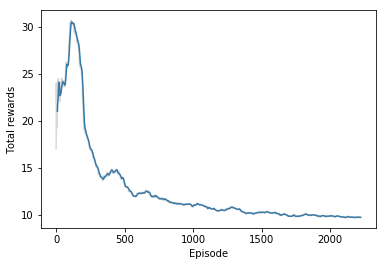

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

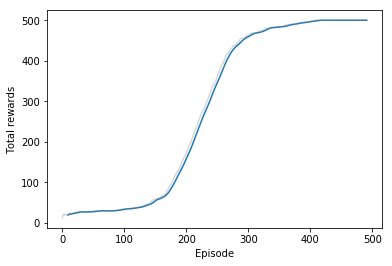

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

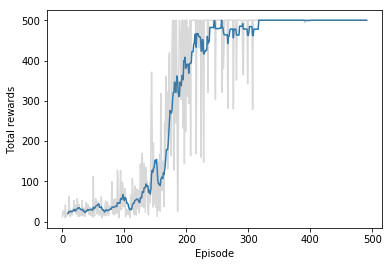

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.